# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

Write the problem in your own words here

In [1]:
#import your libraries
import numpy as np
import pandas as pd
import sklearn as sk
import os
import sys

from matplotlib import pyplot as plt
import seaborn as sns

from helper import explore_data,monotomic_rel

#your info here
__author__ = "Vijayan Nallasami"
__email__ = "VNallasami@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [2]:
os.listdir("data/") 

['test_features.csv', 'train_features.csv', 'train_salaries.csv']

In [3]:
#load the data into a Pandas dataframe

train_features = pd.read_csv("data/train_features.csv")
train_salaries = pd.read_csv("data/train_salaries.csv")
test_features = pd.read_csv("data/test_features.csv")

In [4]:
train = pd.merge(train_features,train_salaries, on='jobId')

In [5]:
explore_data(train_features)

,types,counts,distincts,nulls,missing ratio,uniques,skewness,kurtosis
jobId,object,1000000,1000000,0,0.0,"[[JOB1362684407687, JOB1362684407688, JOB13626...",NaN,NaN
companyId,object,1000000,63,0,0.0,"[[COMP37, COMP19, COMP52, COMP38, COMP7, COMP1...",NaN,NaN
jobType,object,1000000,8,0,0.0,"[[CFO, CEO, VICE_PRESIDENT, MANAGER, JUNIOR, J...",NaN,NaN
degree,object,1000000,5,0,0.0,"[[MASTERS, HIGH_SCHOOL, DOCTORAL, BACHELORS, N...",NaN,NaN
major,object,1000000,9,0,0.0,"[[MATH, NONE, PHYSICS, CHEMISTRY, COMPSCI, BIO...",NaN,NaN
industry,object,1000000,7,0,0.0,"[[HEALTH, WEB, AUTO, FINANCE, EDUCATION, OIL, ...",NaN,NaN
yearsExperience,int64,1000000,25,0,0.0,"[[10, 3, 8, 2, 23, 9, 1, 17, 24, 7, 21, 13, 11...",0.001674,-1.205127
milesFromMetropolis,int64,1000000,100,0,0.0,"[[83, 73, 38, 17, 16, 31, 24, 70, 54, 68, 30, ...",-0.001139,-1.199019


In [ ]:
explore_data(train_salaries)

In [ ]:
explore_data(test_features)

In [ ]:
explore_data(train)

In [ ]:
#look for duplicate data, invalid data (e.g. salaries <=0), or corrupt data and remove it
train.describe()

### ---- 3 Clean the data ----

In [107]:
job_dict = {'JANITOR':8,'JUNIOR':7,'SENIOR':6,'MANAGER':5,'VICE_PRESIDENT':4,'CTO':3,'CFO':2,'CEO':1}

train['jobType'] = train['jobType'].map(job_dict)

train.jobType.unique()

array([2, 1, 4, 5, 7, 8, 3, 6], dtype=int64)

In [108]:
train.degree.unique()

degree_dict = {'DOCTORAL':1,'MASTERS':2,'BACHELORS':3,'HIGH_SCHOOL':4,'NONE':5}

train.degree = train.degree.map(degree_dict)

train.degree.unique()

array([2, 4, 1, 3, 5], dtype=int64)

In [109]:
train.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,2,2,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,1,4,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,4,1,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,5,1,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,4,3,PHYSICS,FINANCE,8,16,163


### ---- 4 Explore the data (EDA) ----

In [ ]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

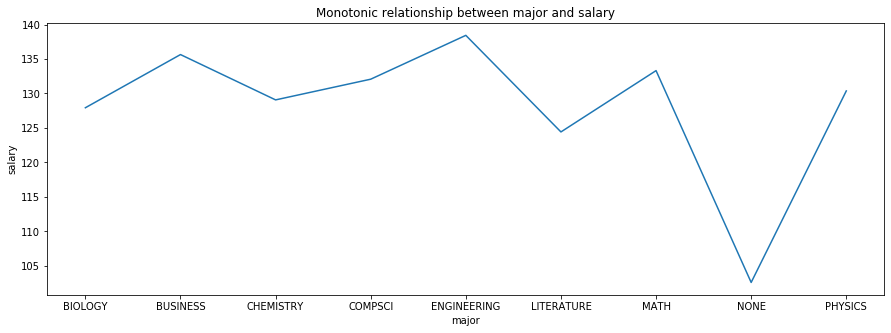

In [112]:
plt.figure(figsize=(15,5))

train.groupby(['major'])['salary'].mean().plot()
plt.title('Monotonic relationship between {} and {}'.format('major','salary'))
plt.ylabel('salary')
# xmarks=[i for i in range(1,max(train.degree)+1,1)]
# plt.xticks(xmarks)

plt.show()

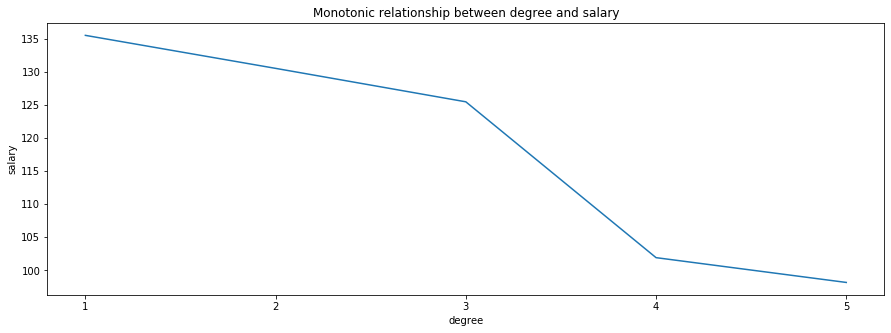

In [111]:
plt.figure(figsize=(15,5))

train.groupby(['degree'])['salary'].mean().plot()
plt.title('Monotonic relationship between {} and {}'.format('degree','salary'))
plt.ylabel('salary')
xmarks=[i for i in range(1,max(train.degree)+1,1)]

plt.xticks(xmarks)

plt.show()

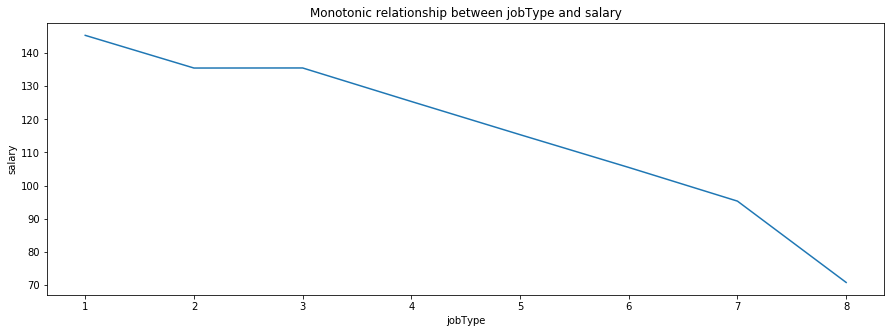

In [110]:
plt.figure(figsize=(15,5))

train.groupby(['jobType'])['salary'].mean().plot()
plt.title('Monotonic relationship between {} and {}'.format('jobType','salary'))
plt.ylabel('salary')

plt.show()

### ---- 5 Establish a baseline ----

In [ ]:
#select a reasonable metric (MSE in this case)
#create an extremely simple model and measure its efficacy
#e.g. use "average salary" for each industry as your model and then measure MSE
#during 5-fold cross-validation

### ---- 6 Hypothesize solution ----

In [ ]:
#brainstorm 3 models that you think may improve results over the baseline model based
#on your 

Brainstorm 3 models that you think may improve results over the baseline model based on your EDA and explain why they're reasonable solutions here.

Also write down any new features that you think you should try adding to the model based on your EDA, e.g. interaction variables, summary statistics for each group, etc

## Part 3 - DEVELOP

You will cycle through creating features, tuning models, and training/validing models (steps 7-9) until you've reached your efficacy goal

#### Your metric will be MSE and your goal is:
 - <360 for entry-level data science roles
 - <320 for senior data science roles

### ---- 7 Engineer features  ----

In [ ]:
#make sure that data is ready for modeling
#create any new features needed to potentially enhance model

### ---- 8 Create models ----

In [ ]:
#create and tune the models that you brainstormed during part 2

### ---- 9 Test models ----

In [ ]:
#do 5-fold cross validation on models and measure MSE

### ---- 10 Select best model  ----

In [ ]:
#select the model with the lowest error as your "prodcuction" model

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [ ]:
#write script that trains model on entire training set, saves model to disk,
#and scores the "test" dataset

### ---- 12 Deploy solution ----

In [ ]:
#save your prediction to a csv file or optionally save them as a table in a SQL database
#additionally, you want to save a visualization and summary of your prediction and feature importances
#these visualizations and summaries will be extremely useful to business stakeholders

### ---- 13 Measure efficacy ----

We'll skip this step since we don't have the outcomes for the test data